tl;dr: I need to re-run these experiments.

The validation scores are not close enough given the minimum loss found is 0.092. 25% of the scores do not meet the generous tolerance of 0.005 score difference .

Even if I select the scores that only made the decisions AND filter for the decently-performing models, the 90% is 0.01 – too high.

In [33]:
import json
import pandas as pd
today = "2019-03-24"

In [34]:
import json
def read_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

In [35]:
# list of arrays for each model.
# DIR = "./"
DIR = f"./out/{today}/"
DIR = f"out/{today}/out/"
cv_results = {alg: read_json(DIR + f"{today}-{alg}-cv_results.json") for alg in ["hyperband", "hyperband-w-patience", "patience"]}

# list of arrays with each score/time/etc. Each model entered more than once.

# ordered by adaptive-ness
ALGS = [
    # "passive",
    "patience",
    "hyperband-w-patience",
    "hyperband",
]
histories = {alg: read_json(DIR + f"{today}-{alg}-history.json")for alg in ALGS}
params = {alg: read_json(DIR + f"{today}-{alg}-params.json") for alg in ALGS}

best = {alg: read_json(DIR + f"{today}-{alg}-best-params-and-score.json") for alg in ALGS}

In [36]:
tuple({1: 2, 3:4}.items())

((1, 2), (3, 4))

In [46]:
def get_dataframe(history):
    df = pd.DataFrame(history)
    df["model_fit_id"] = df.apply(lambda row: hash((row["estimator_id"], row["partial_fit_calls"], tuple(row["params"].items()))), axis=1)
    df = df.sort_values(by=["estimator_id", "partial_fit_calls"])
    df.set_index("model_fit_id", inplace=True)
    return df

In [47]:
df = get_dataframe(histories["hyperband"])
df_patience = get_dataframe(histories["hyperband-w-patience"])

In [48]:
assert df.iloc[0]["params"] == df_patience.iloc[0]["params"]

In [49]:
df.head()

,bracket,elapsed_wall_time,estimator_id,params,partial_fit_calls,partial_fit_time,score,score_time
model_fit_id,,,,,,,,
373486294402116136,0,15.245532,bracket=0-0,"{'train_split': None, 'optimizer__weight_decay...",1,2.332337,-0.673221,1.230465
373505134593572878,0,536.209758,bracket=0-0,"{'train_split': None, 'optimizer__weight_decay...",243,1.338898,-0.200161,0.808645
3707085971293667730,0,15.245533,bracket=0-1,"{'train_split': None, 'optimizer__weight_decay...",1,2.071613,-0.671016,1.306991
3707103933084780432,0,536.209759,bracket=0-1,"{'train_split': None, 'optimizer__weight_decay...",243,1.760090,-0.153987,1.191262
6233485433123325580,0,15.245534,bracket=0-2,"{'train_split': None, 'optimizer__weight_decay...",1,2.390669,-0.256124,1.224128


In [50]:
if "params" in df:
    df.drop(columns=["params"], inplace=True)
if "params" in df_patience:
    df_patience.drop(columns=["params"], inplace=True)

In [69]:
df = pd.merge(df, df_patience, how="inner", on="model_fit_id")

In [70]:
df.head()

,bracket_x,elapsed_wall_time_x,estimator_id_x,partial_fit_calls_x,partial_fit_time_x,score_x,score_time_x,bracket_y,elapsed_wall_time_y,estimator_id_y,partial_fit_calls_y,partial_fit_time_y,score_y,score_time_y
model_fit_id,,,,,,,,,,,,,,
373486294402116136,0,15.245532,bracket=0-0,1,2.332337,-0.673221,1.230465,0,15.270306,bracket=0-0,1,2.226943,-0.672419,0.808640
373505134593572878,0,536.209758,bracket=0-0,243,1.338898,-0.200161,0.808645,0,566.523091,bracket=0-0,243,1.486827,-0.195969,0.941732
3707085971293667730,0,15.245533,bracket=0-1,1,2.071613,-0.671016,1.306991,0,15.270308,bracket=0-1,1,2.188463,-0.672667,1.122812
3707103933084780432,0,536.209759,bracket=0-1,243,1.760090,-0.153987,1.191262,0,566.523093,bracket=0-1,243,1.461800,-0.155387,1.059299
6233485433123325580,0,15.245534,bracket=0-2,1,2.390669,-0.256124,1.224128,0,15.270308,bracket=0-2,1,2.036705,-0.255669,1.164697


In [127]:
df["score_diff"] = np.abs(df.score_x - df.score_y)

0.004063156247138978

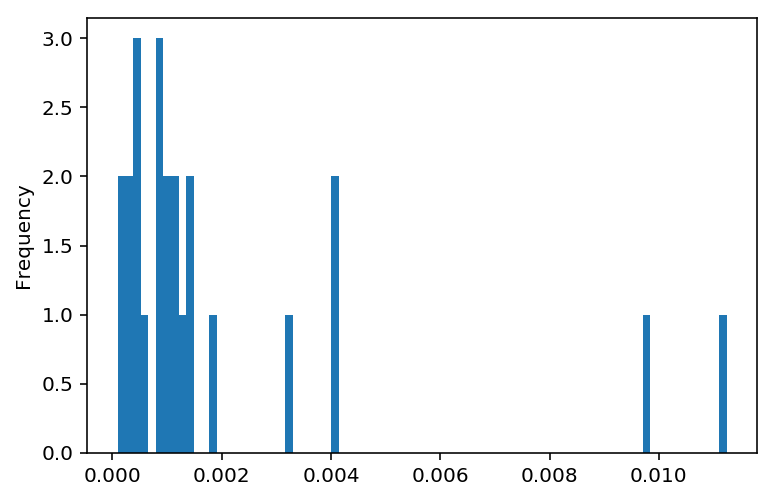

In [169]:
idx = df.groupby("estimator_id_x")["partial_fit_calls_x"].idxmax()
final_scores = df.loc[idx]
good_final_scores = final_scores[np.abs(final_scores.score_x) <= 0.12]
good_final_scores.score_diff.plot.hist(bins=80)
good_final_scores.score_diff.quantile(0.90)

337
150
25% of points are bad with tol=0.005


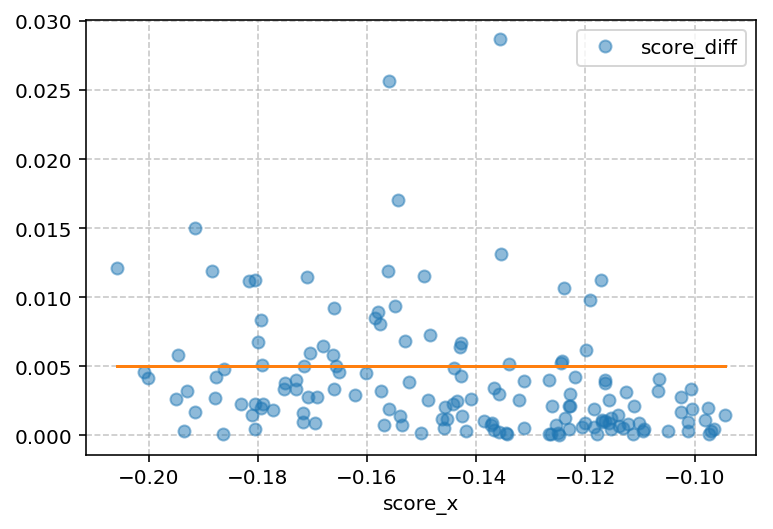

In [151]:
import altair as alt
print(len(df))
show = df[np.abs(df.score_x + df.score_y) <= 2 * (0.2)]
print(len(show))
ax = show.plot(x="score_x", y="score_diff", style="o", alpha=0.5)
ax.grid(linestyle="--", alpha=0.7)
tol = 0.005
ax.plot([show.score_x.min(), show.score_x.max()], [tol, tol])

bad = (show.score_diff >= tol).sum() / len(show.score_diff)
print(f"{100 * bad:2.0f}% of points are bad with tol={tol}")

In [121]:
import numpy as np
i = np.abs(df.score_x) < 0.2
s1 = df.loc[i, "score_x"]
s2 = df.loc[i, "score_y"]
print(s1.min())

0.004572732927831444

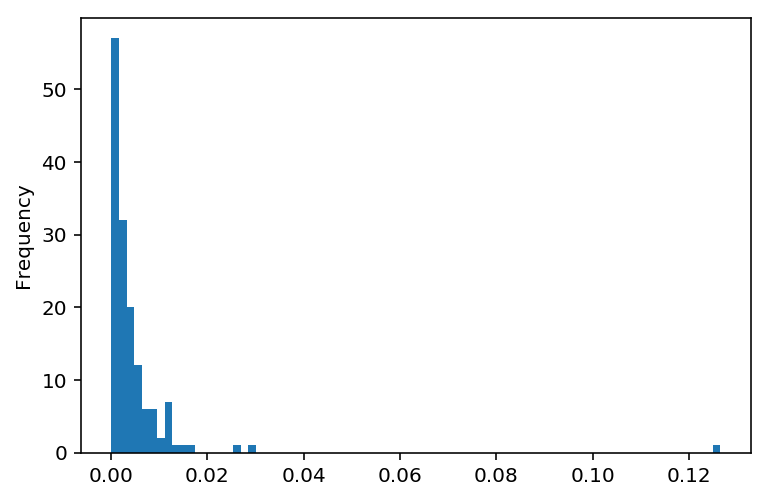

In [126]:
score_diff = np.abs(s1 - s2)
score_diff.plot.hist(bins=80)
score_diff.mean()

0.03009504652508705
0.017251886052523785
[0.0007149472832679749, 0.0018180966377258304, 0.003207962214946747, 0.005811706185340881, 0.009501583874225622, 0.01176922470331192]


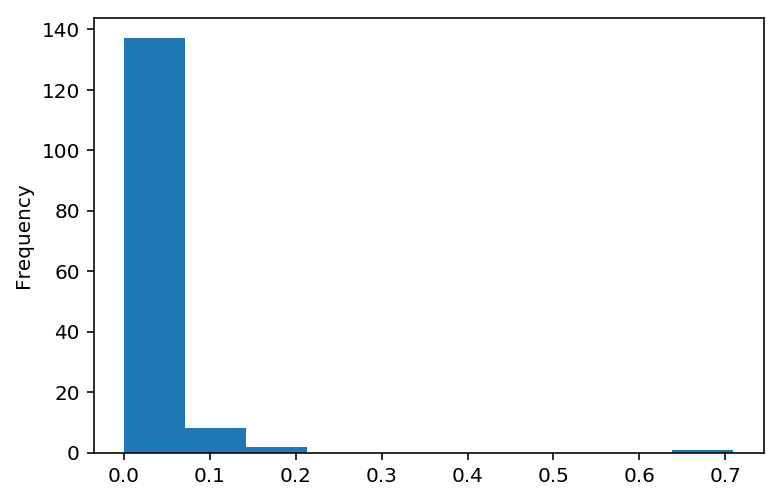

In [122]:
percent_diff = score_diff / np.abs(s1)
print(percent_diff.mean())
print(percent_diff.median())
print([score_diff.quantile(x) for x in [0.2, 0.4, 0.6, 0.8, 0.9, 0.95]])
percent_diff.plot.hist(bins=10)